In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import feature
from sklearn.preprocessing import Normalizer,Imputer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from scipy.stats import skew
from sklearn.feature_selection import f_regression
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_file = "../data/train.csv"
test_file = "../data/test.csv"
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [3]:
print("Looking for the null value in the training dataset...")
feature.simple_explore(train_data)

print("Looking for the null value in the test dataset...")
feature.simple_explore(test_data)

Looking for the null value in the training dataset...
The shape of the DataFrame is [1460,81]
The list below are the columns that has NaN values:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
Looking for the null value in the test dataset...
The shape of the DataFrame is [1459,80]
The list below are the columns that has NaN values:
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFi

# Data Preparations
A general assumption for the machine learning is that the training and test data are all [independent and identically distributed (_i.i.d._)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) from the same probability distribution. Therefore, the first step for the data clean up is always to __combine the training data and test data__.

In [4]:
cleaner = feature.DataCleaner(train_data, test_data)

The common columns are: 
['GarageQual', 'Functional', 'FullBath', 'MoSold', 'ExterQual', 'FireplaceQu', 'SaleType', 'Condition2', '3SsnPorch', 'Fireplaces', 'MSSubClass', 'BedroomAbvGr', 'GrLivArea', 'Foundation', 'BsmtHalfBath', 'GarageArea', 'LotFrontage', 'Street', 'BsmtFinType2', 'Id', 'BldgType', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'KitchenAbvGr', 'Exterior1st', 'OverallCond', 'OverallQual', 'GarageYrBlt', 'PoolQC', 'Neighborhood', 'Heating', 'MSZoning', 'GarageType', 'MasVnrType', 'EnclosedPorch', 'ScreenPorch', 'LotShape', 'GarageCond', 'ExterCond', 'TotalBsmtSF', 'LowQualFinSF', 'PavedDrive', 'Condition1', 'LotConfig', 'LotArea', 'BsmtExposure', 'HouseStyle', 'BsmtFinSF2', 'MiscFeature', 'YearRemodAdd', 'RoofStyle', 'BsmtFinSF1', 'Alley', 'MiscVal', 'GarageCars', 'BsmtQual', 'RoofMatl', 'BsmtFinType1', 'GarageFinish', 'Utilities', 'BsmtCond', 'Electrical', 'HalfBath', 'PoolArea', 'Fence', 'SaleCondition', 'TotRmsAbvGrd', 'OpenPorchSF', 'MasVnrArea', 'BsmtUnfSF', 'KitchenQua

From the data descriptions, there are many variables which have NaN that need to be considered as absence of the property.

In [5]:
fill_dict = {"NoBsmt": ["BsmtFinType1", "BsmtCond", "BsmtFinType2", "BsmtExposure", "BsmtQual"],
             "NoGarage": ["GarageCond", "GarageQual", "GarageFinish", "GarageType"],
             "NoPool": ["PoolQC"],
             "NoFirePlace": ["FireplaceQu"],
             "NoFence":["Fence"],
             "NoAccess": ["Alley"],
             "None": ["MiscFeature", "MasVnrType"]
             }
cleaner.fill_na_spec(fill_dict)

Now the column name(s) that have empty values are:
Functional        2
SaleType          1
BsmtHalfBath      2
GarageArea        1
LotFrontage     486
BsmtFullBath      2
Exterior1st       1
GarageYrBlt     159
MSZoning          4
TotalBsmtSF       1
BsmtFinSF2        1
BsmtFinSF1        1
GarageCars        1
Utilities         2
Electrical        1
MasVnrArea       23
BsmtUnfSF         1
KitchenQual       1
Exterior2nd       1
dtype: int64


In the variables related to garage, there is one empty value in `GarageArea` and `GarageCars` when it has the `GarageType = Detchd`. So one can impute the missing value with the median value of the `GarateArea` when `GarageType = Detchd`. 

In [6]:
print ("The GarageType is " + cleaner.all_data.loc[cleaner.all_data.GarageArea.isnull(),'GarageType'] + 
       ", when the Garage Area is empty")
group = {("GarageType", "Detchd"): ["GarageArea", "GarageCars"] }
cleaner.fill_na_group(group)

2576    The GarageType is Detchd, when the Garage Area...
Name: GarageType, dtype: object
Now the column name(s) that have empty values are:
Functional        2
SaleType          1
BsmtHalfBath      2
LotFrontage     486
BsmtFullBath      2
Exterior1st       1
GarageYrBlt     159
MSZoning          4
TotalBsmtSF       1
BsmtFinSF2        1
BsmtFinSF1        1
Utilities         2
Electrical        1
MasVnrArea       23
BsmtUnfSF         1
KitchenQual       1
Exterior2nd       1
dtype: int64


In [7]:
# Now one can impute the missing variables with most common values
cleaner.fill_na_gen()

There are no empty values in the dataset.


In [8]:
SubClass_mapping = { 20: "SubClass_20",
                     30: "SubClass_30",
                     40: "SubClass_40",
                     45: "SubClass_45",
                     50: "SubClass_50",
                     60: "SubClass_60",
                     70: "SubClass_70",
                     75: "SubClass_75",
                     80: "SubClass_80",
                     85: "SubClass_85",
                     90: "SubClass_90",
                     120: "SubClass_120",
                     150: "SubClass_150",
                     160: "SubClass_160",
                     180: "SubClass_180",
                     190: "SubClass_190"}
print("The running time for mapping...")
%timeit cleaner.all_data['MSSubClass'].map(SubClass_mapping)
print("The running time for applying...")
%timeit cleaner.all_data["MSSubClass"].apply(lambda x: "_".join(['SubClass',str(x)]))

The running time for mapping...
1000 loops, best of 3: 433 µs per loop
The running time for applying...
1000 loops, best of 3: 1.5 ms per loop


It looks like mapping is way faster than apply funciton.

In [9]:
interpret_mapping = {
    'MSSubClass': { 20: "SubClass_20",
                     30: "SubClass_30",
                     40: "SubClass_40",
                     45: "SubClass_45",
                     50: "SubClass_50",
                     60: "SubClass_60",
                     70: "SubClass_70",
                     75: "SubClass_75",
                     80: "SubClass_80",
                     85: "SubClass_85",
                     90: "SubClass_90",
                     120: "SubClass_120",
                     150: "SubClass_150",
                     160: "SubClass_160",
                     180: "SubClass_180",
                     190: "SubClass_190"},
    'Street': { 'Grvl' : 0,
                'Pave': 1},
    'Alley': { 'Grvl': 0,
               'Pave': 1,
               'NoAccess': -1},
    'LotShape': {'Reg' : 0,
                 'IR1' : 1,
                 'IR2' : 2,
                 'IR3' : 3 },
    'Utilities': {'AllPub': 3,
                  'NoSewr' : 2,
                  'NoSeWa': 1,
                  'ELO': 0},
    'LandSlope': {'Gtl' : 0,
                  'Mod' : 1,
                  'Sev' : 2},
    'ExterQual': {'Ex' : 5,
                  'Gd' : 4,
                  'TA' : 3,
                  'Fa' : 2,
                  'Po' : 1},
    'ExterCond': {'Ex' : 5,
                  'Gd' : 4,
                  'TA' : 3,
                  'FA' : 2,
                  'Po' : 1},
    'BsmtQual': {'Ex' : 5,
                 'Gd' : 4,
                 'TA' : 3,
                 'Fa' : 2,
                 'Po' : 1,
                 'NoBsmt' : 0},
    'BsmtCond': {'Ex' : 5,
                 'Gd' : 4,
                 'TA' : 3,
                 'Fa' : 2,
                 'Po' : 1,
                 'NoBsmt' : 0},
    'BsmtExposure' : {'Gd' : 3,
                      'Av' : 2,
                      'Mn' : 1,
                      'No' : 0,
                      'NoBsmt' : 0},
    'HeatingQC' :{'Ex' : 5,
                  'Gd' : 4,
                  'TA' : 3,
                  'Fa' : 2,
                  'Po' : 1},
    'CentralAir' :{'N' : 0,
                   'Y' : 1},
    'KitchenQual' :{'Ex' : 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1},
    'Functional' : {'Typ' : 0,
                    'Min1' : 1,
                    'Min2' : 1,
                    'Mod' : 2,
                    'Maj1' : 3,
                    'Maj2' : 3,
                    'Sev' : 4,
                    'Sal' : 5},
    'FireplaceQu' : {'Ex' : 5,
                     'Gd' : 4,
                     'TA' : 3,
                     'Fa' : 2,
                     'Po' : 1,
                     },
    'GarageFinish' : {'Fin' : 2,
                      'RFn' : 1,
                      'Unf' : 0,
                      'NoGarage': 0},
    'GarageQual' : {'Ex' : 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1,
                    'NoGarage': 0},
    'GarageCond' : {'Ex': 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1,
                    'NoGarage' : 0},
    'PavedDrive' : {'Y' : 2,
                    'P' : 1,
                    'N' : 0},
    'PoolQC' : {'Ex' : 4,
                'Gd' : 3,
                'TA' : 2,
                'Fa' : 1,
                'NoPool': 0},
    'Fence'  : {'GdPrv': 2,
                'MnPrv': 1,
                'GdWo': 2,
                'MnWw': 1,
                'NoFence': 0
                },
}
cleaner.interpret_value(interpret_mapping)

# Remove Skew from Price values
After exploring the distribution of the price values, we can take the logarithm to change the shape of the variable to reduce the skewness of the variables.

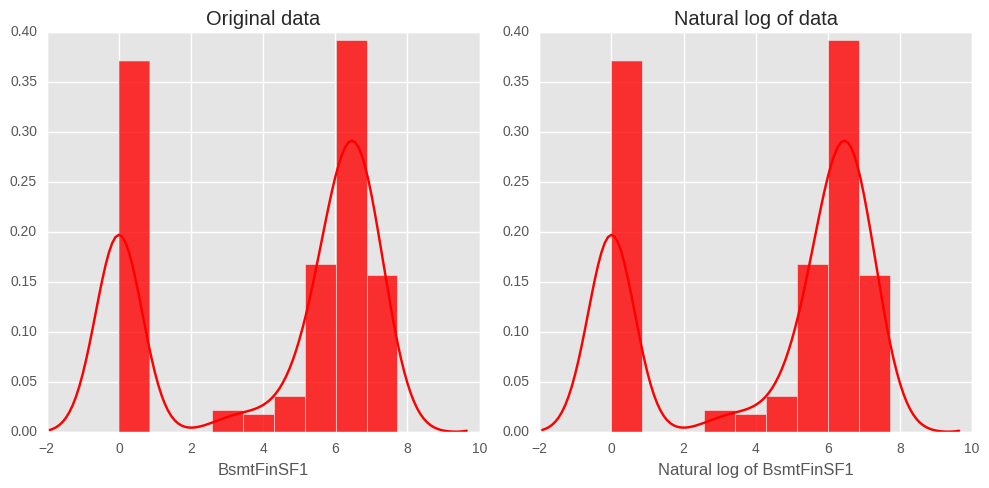

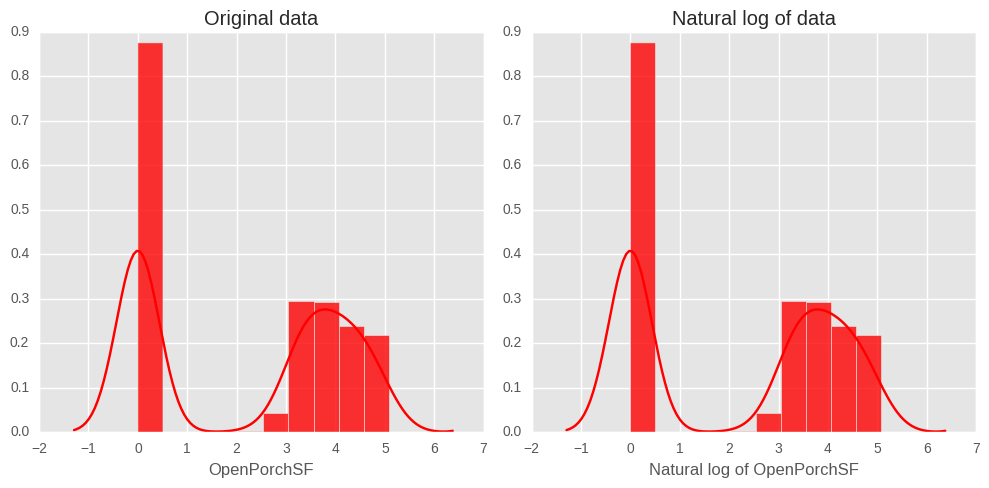

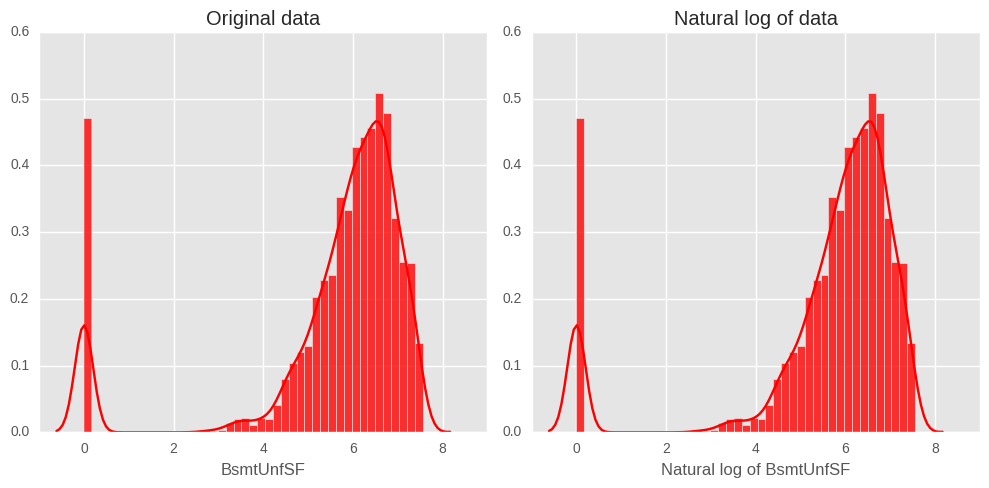

In [10]:
exclusion = ['Street', 'PravedDrive', 'Fence', 'GarageCond', 'GarageQual', 'GarageFinish', 'Id', 'Alley', 'LotShape',
             'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure', 'HeatingQC',
             'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'OverallQual', 'OverallCond','YearBuilt',
             'YearRemodAdd','GarageYrBlt', 'MoSold', 'YrSold']
cleaner.normalize_numerical(True,exclusion)

In [11]:
X_train, X_test, y = cleaner.prep_for_learn()
print(X_train.shape)
print(y.shape)
print(X_test.shape)

(1460, 258)
(1460,)
(1459, 258)


In [12]:
y = np.log1p(y)

In [13]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

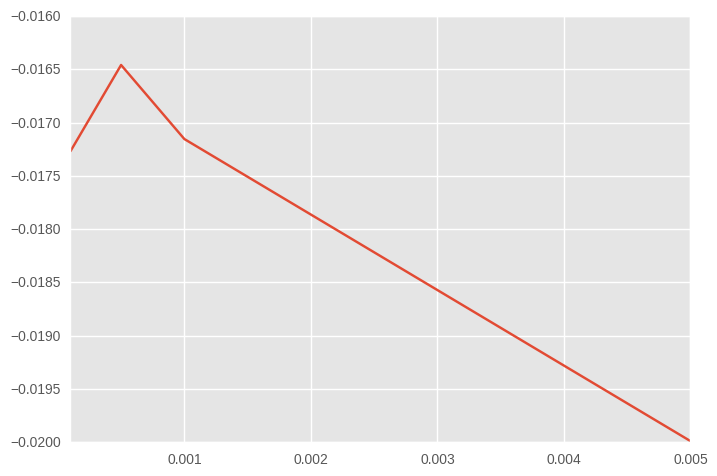

In [15]:
from sklearn.linear_model import Lasso
alphas = [1e-4, 5e-4, 1e-3, 5e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [16]:
model = Lasso(alpha = 5e-4, max_iter =  50000).fit(X_train, y)

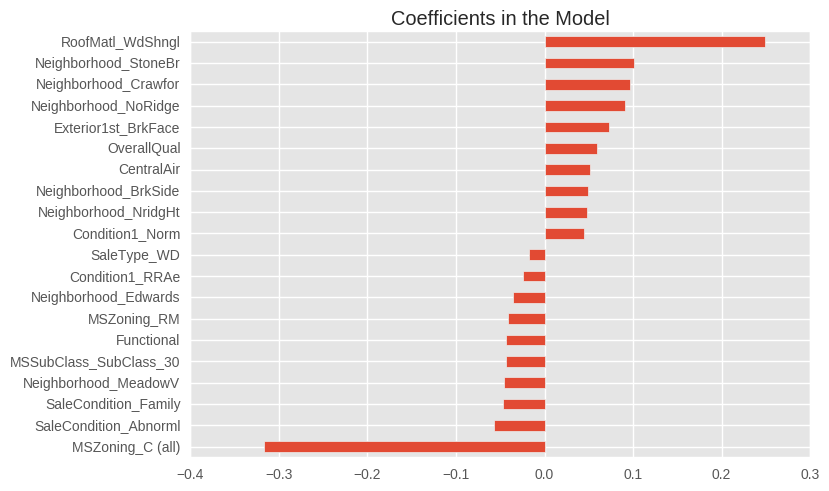

In [17]:
coef = pd.Series(model.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

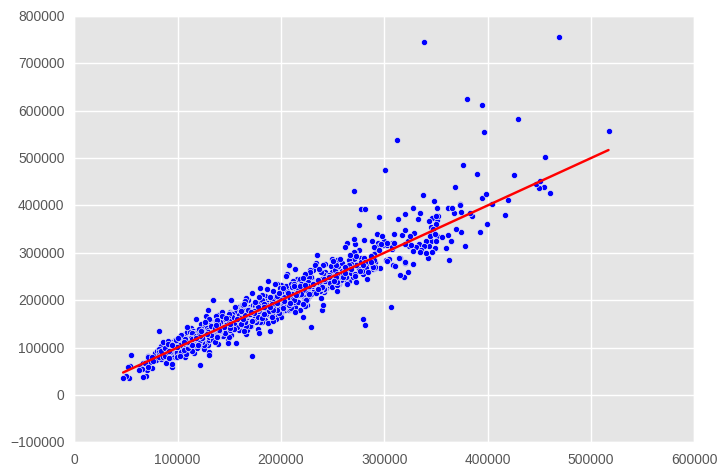

In [18]:
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

In [21]:
# save to file to make a submission
p = np.expm1(model.predict(X_test))
solution = pd.DataFrame({"id":test_data.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("test.csv", index = False)

In [ ]:
import seaborn as sns
price = train_data[train_data.columns.values[-1]]
log_price = np.log(price)
print ("The skewness of the price is {0}".format(skew(price)))

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
sns.distplot(price, color = 'r', hist_kws = {'alpha': 0.9})
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_price, color = 'r', hist_kws = {'alpha': 0.9})
plt.title('Natual log of Data')
plt.xlabel('Natual log of Sale Price')
plt.tight_layout()

# Handling missing values for numerical variables
* Remove outliers using Median Absolute Deviation
* Calculate skewness of each variable and transform it if greater than 0.75
* Apply the sklearn.Normalizer to each column

  We can compare two different numerical variables: one with skewness handling and normalization, one without it.

In [ ]:
train_num_m = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
train_num = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
for col in train_num_m.columns.values:
    if np.sum(train_num_m[col].isnull() ) > 0:
        median = train_num_m[col].median()
        idx = np.where(train_num_m.isnull())[0]
        train_num_m[col].iloc[idx] = median
        train_num[col].iloc[idx] = median
        
        outliers = np.where(is_outlier(train_num_m[col]))
        train_num_m[col].iloc[outliers] = median
        
        if skew(train_num_m[col]) > 0.75:
            train_num_m[col] = np.log(train_num[col])
            train_num_m[col] = train_num_m[col].apply(lambda x: 0 if x == -np.inf else x)
            
        train_num_m[col] = Normalizer().fit_transform(train_num_m[col].reshape(1,-1))[0]

In [ ]:
train_num_m[train_num_m.columns.values[-1]] = np.log(train_num_m[train_num_m.columns.values[-1]])
corr_m = train_num_m.corr()
corr = train_num.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, vmax =1 , square = True)
plt.figure(figsize = (15,15))
sns.heatmap(corr, vmax=1, square = True)

In [ ]:
cor_dict_m = corr_m['SalePrice'].to_dict()
del cor_dict_m['SalePrice']

# raw numerical features
cor_dict = corr["SalePrice"].to_dict()
del cor_dict['SalePrice']

print("The raw numerical features sorted by their correlation with Sale price:\n")
for item in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t {1}".format(*item))

print("\n\nThe modified numerical features sorted by their correlation with Sale price:\n")
for item in sorted(cor_dict_m.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t {1}".format(*item))

In [ ]:
sns.regplot(x='OverallQual', y='SalePrice', data = train_num_m, color='Orange')

In [ ]:
fig = plt.figure()
plt.scatter(train_num_m.YearBuilt.values, train_num_m.YearRemodAdd.values)
plt.title("Year Built")
fig.text(-0.01,0.5, 'Year Remodel Added', va="center", rotation = 'vertical', fontsize = 12)
print (corr_m['YearBuilt']['YearRemodAdd'])

In [ ]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.scatter(train_num_m.GarageCars.values, train_num_m.GarageArea.values)
plt.title("Size of Garage for Cars")
fig.text(-0.01,0.5, 'Size of Garage area', va="center", rotation = 'vertical', fontsize = 12)
print(corr_m['GarageCars']['GarageArea'])
plt.subplot(1,2,2)
sns.regplot(x='GarageCars', y='GarageArea', data = train_num_m, color='Orange')

In [ ]:
fig = plt.figure()
plt.scatter(train_num_m.GarageArea.values, train_num_m.GarageYrBlt.values)
plt.title("Size of Garage")
fig.text(-0.01,0.5, 'The building year for garage', va="center", rotation = 'vertical', fontsize = 12)
print(corr_m['GarageArea']['GarageYrBlt'])

In [ ]:
fig = plt.figure()
plt.scatter(train_num_m.YearBuilt.values, train_num_m.GarageYrBlt.values)
plt.title("Year Built")
fig.text(-0.01,0.5, 'The year build the garage', va="center", rotation = 'vertical', fontsize = 12)
print(corr_m['YearBuilt']['GarageYrBlt'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Campare the importances of RF for raw and modified features
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
y = train_num['SalePrice']
X= train_num.drop('SalePrice', axis=1)

rfr.fit(X,y)
coef = pd.Series(rfr.feature_importances_, index = X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
coef.head(25).plot(kind='bar')
plt.title('Raw Feature Significance for random forest')
plt.tight_layout()

rfr_m = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
y_m = train_num_m['SalePrice']
X_m= train_num_m.drop('SalePrice', axis=1)

rfr_m.fit(X_m,y_m)
coef_m = pd.Series(rfr_m.feature_importances_, index = X_m.columns).sort_values(ascending=False)

plt.subplot(1,2,2)
coef_m.head(25).plot(kind='bar')
plt.title('Modified Feature Significance for random forest')
plt.tight_layout()

In [ ]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=1000)
gbr.fit(X,y)
coef = pd.Series(gbr.feature_importances_, index = X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
coef.head(25).plot(kind='bar')
plt.title('Raw Feature Significance for gradient boosting trees')
plt.tight_layout()

gbr_m = GradientBoostingRegressor(loss='ls', n_estimators=1000)
y_m = train_num_m['SalePrice']
X_m= train_num_m.drop('SalePrice', axis=1)

gbr_m.fit(X_m,y_m)
coef_m = pd.Series(gbr_m.feature_importances_, index = X_m.columns).sort_values(ascending=False)

plt.subplot(1,2,2)
coef_m.head(25).plot(kind='bar')
plt.title('Modified Feature Significance for gradient boosting trees')
plt.tight_layout()

In [ ]:
_,pval = f_regression(X, y)
coef = pd.Series(pval, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
coef.head(25).plot(kind='bar')
plt.title('Raw Feature Significance')
plt.tight_layout()

_,pval_m = f_regression(X_m, y)
coef_m = pd.Series(pval_m, index=X_m.columns).sort_values(ascending=True)

plt.subplot(1,2,2) 
coef_m.head(25).plot(kind='bar')
plt.title('Modified Feature Significance')
plt.tight_layout()

# Categorical Variables

In [ ]:
cat_value = train_data.select_dtypes(include=['object']).iloc[:,1:]

In [ ]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = train_data)
xt = plt.xticks(rotation = 45)

In [ ]:
plt.figure (figsize = (12, 6))
sns.countplot(x = 'Neighborhood', data = cat_value)
xt = plt.xticks(rotation = 45)